In [855]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.inspection import permutation_importance
import joblib

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# print(train_data.hist(figsize=(20,20)))

# columnsToDrop = ['Sex',
#                  'Education',
#                  'AnyHealthcare',
#                  'HighChol',
#                  'CholCheck',
#                  'HvyAlcoholConsump',
#                  'NoDocbcCost',
#                  'Smoker',
#                  'Stroke',
#                  'HeartDiseaseorAttack',
#                  'PhysHlth',
#                  'MentHlth',
#                  'Fruits',
#                  'Veggies',
#                  'DiffWalk'
#                  ]
# 
# train_data = train_data.drop(columns=columnsToDrop)
# test_data = test_data.drop(columns=columnsToDrop)

# categorical_cols = [
#     'Age',
#     # 'Sex',
#     'Income',
#     # 'Education'
# ] # here we will use OneHot (convert to numeric data)
# numerical_cols = [
#     'BMI',
#     # 'PhysHlth',
#     'GenHlth',
#     # 'MentHlth'
# ] # here we will use scaling to give a better representation
# # the rest of the columns are binary

numerical_cols = [
    'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
    'MentHlth', 'PhysHlth', 'DiffWalk'
]
categorical_cols = ['Age','Sex','Education','Income']
poly_features = []

def create_interactions(df):
    # Health Conditions Interactions
    df['HighBP_HighChol'] = df['HighBP'] * df['HighChol']
    df['Phys_MentHlth'] = df['PhysHlth'] * df['MentHlth']
    df['HighBP_HeartDiseaseorAttack'] = df['HighBP'] * df['HeartDiseaseorAttack']
    df['DiffWalk_HeartDiseaseorAttack'] = df['DiffWalk'] * df['HeartDiseaseorAttack']
    #Physical Activity and Lifestyle
    df['PhysActivity_Fruits_Veggies'] = df['PhysActivity'] * df['Fruits'] * df['Veggies']
    df['HvyAlcoholConsump_Smoker'] = df['HvyAlcoholConsump'] * df['Smoker']
    #General Health and Age
    df['GenHlth_Age'] = df['GenHlth'] * df['Age']
    df['GenHlth_Age2'] = df['GenHlth'] * df['Age']^2
    #BMI
    df['BMI_Age'] = df['BMI'] * df['Age']
    df['BMI_PhysHlth'] = df['BMI'] * df['PhysHlth']
    #Economic
    df['Income_AnyHealthcare'] = df['Income'] * df['AnyHealthcare']
    df['Education_Income'] = df['Education'] * df['Income']

    # # Polynomial Features
    # poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    # poly_features = ['HighBP', 'HighChol', 'BMI', 'Age']
    # poly_df = pd.DataFrame(poly.fit_transform(df[poly_features]), 
    #                        columns=poly.get_feature_names_out(poly_features))
    # 
    # # Concatenate polynomial features with the original dataframe
    # df = pd.concat([df, poly_df.drop(columns=poly_features)], axis=1)
    
    return df

train_data = create_interactions(train_data)
test_data = create_interactions(test_data)

interactions = [
    'HighBP_HighChol',
    'Phys_MentHlth',
    'HighBP_HeartDiseaseorAttack',
    'DiffWalk_HeartDiseaseorAttack',
    'PhysActivity_Fruits_Veggies',
    'HvyAlcoholConsump_Smoker',
    'GenHlth_Age',
    'GenHlth_Age2',
    'BMI_Age',
    'BMI_PhysHlth',
    'Income_AnyHealthcare',
    'Education_Income',
]

poly_cols = [col for col in train_data.columns if any(pf in col for pf in poly_features)]

numerical_cols += interactions + poly_cols

# Binning BMI into categories
bins = [0, 18.5, 25, 30, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
train_data['BMI_binned'] = pd.cut(train_data['BMI'], bins=bins, labels=labels)
test_data['BMI_binned'] = pd.cut(test_data['BMI'], bins=bins, labels=labels)

categorical_cols.append('BMI_binned')

# Binning Age into categories
bins_age = [0, 4, 6, 8, 10, 13]
labels_age = ['Young Adults', 'Middle-aged Adults', 'Older Adults', 'Senior Adults', 'Elderly Adults']
train_data['Age_binned'] = pd.cut(train_data['Age'], bins=bins_age, labels=labels_age, right=False)
test_data['Age_binned'] = pd.cut(test_data['Age'], bins=bins_age, labels=labels_age, right=False)

categorical_cols.append('Age_binned')

numericalColumnsToDrop = ['BMI']
categoricalColumnsToDrop = ['Age']

for e in numericalColumnsToDrop:
    numerical_cols.remove(e)

for e in categoricalColumnsToDrop:
    categorical_cols.remove(e)

numericalColumnsToDrop.extend(categoricalColumnsToDrop)
train_data = train_data.drop(columns=numericalColumnsToDrop)
test_data = test_data.drop(columns=numericalColumnsToDrop)

X = train_data.drop(columns=['Target','Id'])
y = train_data['Target']

# X = X.head(10000)
# y = y.head(10000)

X_apply = test_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [ ]:
sns.pairplot(train_data.head(100), hue='Target', palette='coolwarm', vars=['BMI','PhysHlth_BMI', 'PhysHlth_GenHlth_Age', 'BMI_GenHlth_Age'])
plt.show()

In [503]:
# Scatter matrix
scatter_matrix(train_data[['BMI_GenHlth_Age', 'HighBP', 'HighChol', 'Target']], figsize=(12, 12), diagonal='kde', color='blue')
plt.suptitle('Scatter Matrix of Key Features and Target', y=0.92)
plt.show()

In [365]:
# Define the scatter plot function
def scatter_plot(df, x_col, y_col, color_col, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df[x_col], df[y_col], c=df[color_col], cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label=color_col)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Create scatter plots for selected features
scatter_plot(train_data, 'GenHlth_Age', 'BMI', 'Target', 'GenHlth_Age vs. BMI colored by Target')
scatter_plot(train_data, 'PhysHlth', 'GenHlth_Age', 'Target', 'PhysHlth vs. GenHlth_Age colored by Target')
scatter_plot(train_data, 'BMI', 'PhysHlth', 'Target', 'BMI vs. PhysHlth colored by Target')

In [869]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

model = ImbPipeline([
    ('preprocessor', preprocessor),
    # ('smote', SMOTE(random_state=27)),
    # ('sampling', RandomUnderSampler(random_state=27)),
    # ('sme', SMOTEENN(random_state=27)),
    ('classifier', RandomForestClassifier(
        random_state=27, 
        class_weight='balanced', 
        criterion='gini',
        n_estimators=300,
        max_depth=30,
        min_samples_split=10,
        min_samples_leaf=1
    )),
    # ('classifier', lgb.LGBMClassifier(random_state=27)),
    # ('classifier', XGBClassifier(
    #     scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    #     random_state=27,
    #     max_depth=10,
    #     colsample_bytree=0.8,
    #     gamma=0.1,
    #     learning_rate=0.1,
    #     min_child_weight=3,
    #     n_estimators=100,
    #     reg_alpha=0,
    #     reg_lambda=100,
    #     subsample=0.6,
    # ))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# param_grid = {
#     'classifier__n_estimators': [100, 200, 500],
#     'classifier__max_depth': [3, 6, 10],
#     'classifier__learning_rate': [0.01, 0.05, 0.1],
#     'classifier__subsample': [0.6, 0.8, 1.0],
#     'classifier__colsample_bytree': [0.6, 0.8, 1.0],
#     'classifier__min_child_weight': [1, 3, 5],
#     'classifier__gamma': [0, 0.1, 0.3],
#     'classifier__reg_alpha': [0, 0.01, 0.1],
#     'classifier__reg_lambda': [1, 10, 100]
# }

# param_grid = {
#     'classifier__learning_rate': [0.01, 0.1],
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [10, 20, 30],
#     'classifier__subsample': [0.8, 1.0],
#     'classifier__colsample_bytree': [0.8, 1.0]
# }
# 
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='balanced_accuracy', verbose=2)
# grid_search.fit(X_train, y_train)
# 
# print("Best parameters found: ", grid_search.best_params_)
# print("Best balanced accuracy score: ", grid_search.best_score_)

# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
#                                     n_iter=1, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=2, random_state=42)
# random_search.fit(X_train, y_train)
# 
# # Get the best parameters
# best_params = random_search.best_params_
# print(f'Best parameters found: {best_params}')
# 
# # Retrain the model with the best parameters
# best_model = random_search.best_estimator_
# 
# # Evaluate the best model
# predictions = best_model.predict(X_test)
# score = balanced_accuracy_score(y_test, predictions)
# 
# print(f'Balanced Accuracy Score with best parameters: {score}')
# print(classification_report(y_test, predictions))

model.fit(X_train,y_train)
print()

In [872]:
joblib.dump(model, 'diabeticPredictor-RF_acc=0.94055_th=0.47305.joblib')
# model = joblib.load('diabeticPredictor-RF_50107.joblib')

predictions = model.predict(X_test)
score = balanced_accuracy_score(y_test, predictions)

print(score)
# print(classification_report(y_test, predictions))

threshold = 0.47305

y_pred_proba = model.predict_proba(X_apply)[:, 1]
predictions = (y_pred_proba > threshold).astype(int)

submission_df = pd.DataFrame({
    'Id': X_apply['Id'],  # Assuming 'Id' is the name of the ID column in X_apply
    'Target': predictions
})

# Save the predictions to a CSV file
submission_df.to_csv('submission-rf_19-09-24.csv', index=False)

# # Print classification report (for your validation data)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Evaluate the model with the validation set
y_pred_val_proba = model.predict_proba(X_val)[:, 1]
val_predictions = (y_pred_val_proba > threshold).astype(int)
val_score = balanced_accuracy_score(y_val, val_predictions)

# Output evaluation metrics for validation data
print(f"Balanced Accuracy Score on Validation: {val_score}")
print(classification_report(y_val, val_predictions))

0.6763786829448557
Balanced Accuracy Score on Validation: 0.94055112572036
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     32138
           1       0.69      0.95      0.80      5153

    accuracy                           0.93     37291
   macro avg       0.84      0.94      0.88     37291
weighted avg       0.95      0.93      0.94     37291



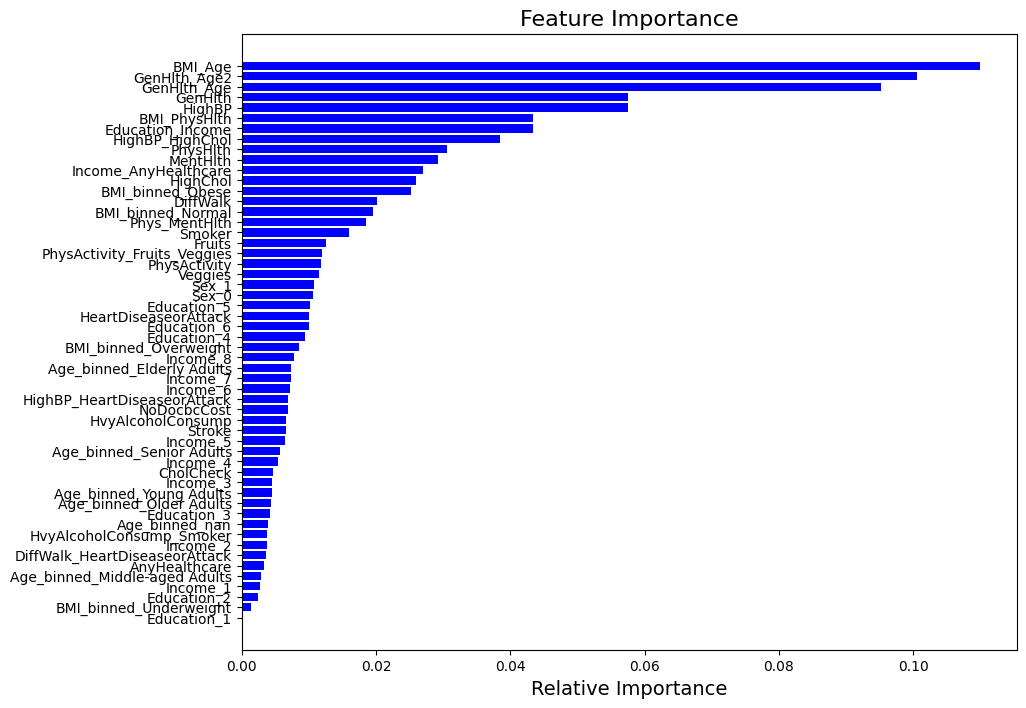

In [873]:
feature_importances = model.named_steps['classifier'].feature_importances_
feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols))

# Sort features by importance
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 8))
plt.title("Feature Importance", fontsize=16)
plt.barh(range(len(indices)), feature_importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance", fontsize=14)
plt.show()

C:\Users\willi\OneDrive - Høgskulen på Vestlandet\Machine Learning Code\DiabeticPrediction\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


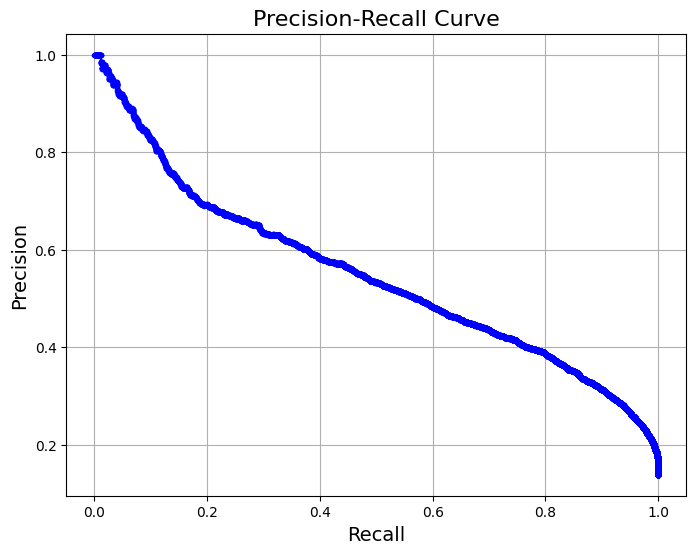

In [559]:
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='b')
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.grid(True)
plt.show()

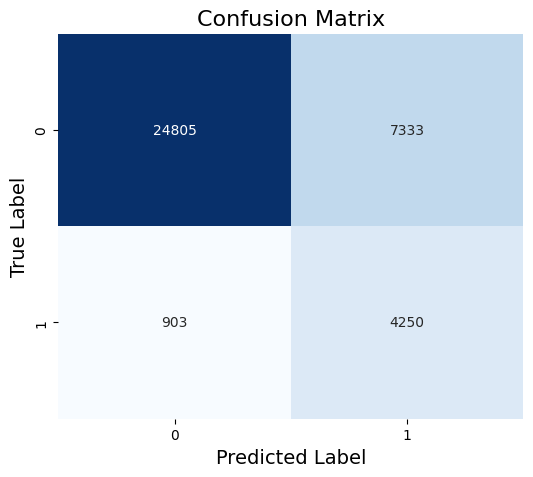

In [560]:
# Get confusion matrix for validation data
conf_matrix = confusion_matrix(y_val, val_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.show()

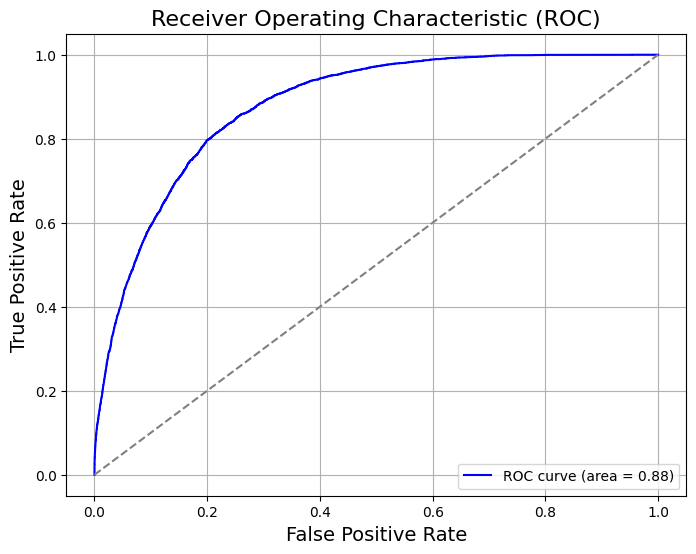

In [562]:
fpr, tpr, threshold = roc_curve(y_val, y_val_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

TypeError: unsupported format string passed to numpy.ndarray.__format__

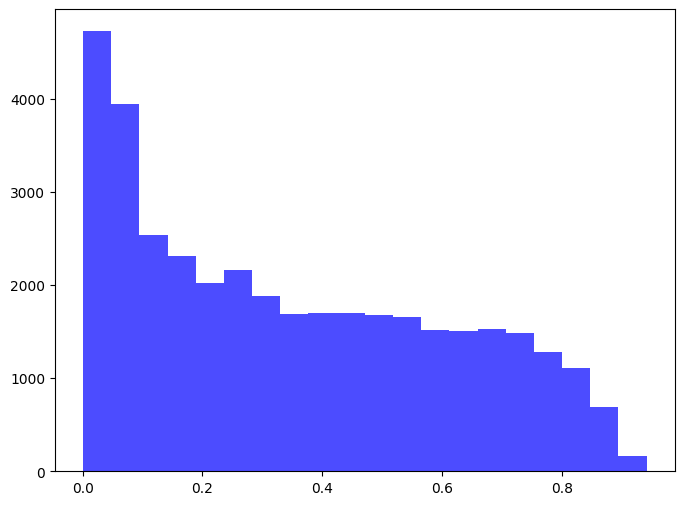

In [563]:
plt.figure(figsize=(8, 6))
plt.hist(y_val_pred_proba, bins=20, color='b', alpha=0.7, label='Predicted Probabilities')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.3f}')
plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.show()